<h1>CE9010 Project</h1>
<h3>by Cassandra Tay, Lim Bang Jin, Tng Jun Wei</h3>

In [1]:
#libraries 
import pandas as pd
import numpy as np 
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

#Geographical distance 
from geopy.distance import distance

#visualization tools 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas
import shapefile as shp
import descartes

from sklearn.utils import shuffle

# 3 Data Cleaning 

The data was scaped from **Property Guru** which contains the following variables: 
1. Address 
2. Building Name 
3. Built On - Year that the building was built 
4. Land Area - Size of the house 
5. No of Bathroom 
6. No of Bedroom 
7. Price 
8. Price per sqft 
9. Tenure 
10. Type of property 
11. Latitude and Longtitude 

**School** and **Mrt** data were merged with the data to obtain the  number of mrt station and primary school within a certain distance for each listing.

* **Propertyguru_loc** contains 8546 listings infomation with 10 variables 
* **school** contains 184 primary schools with 3 variables 
* **Mrt** contains 144 mrt stations in Singapore (Note: Station with more than 1 mrt lines, considered as seperate mrt station)

## 3.1 Data Pre-processing 

The initial pre-processing was conducted in the following process: 
1. Eliminate missing values and values that contain unknown data (e.g unknown tenure). 
2. Remove uncommon houses like shophouse and convervation house from the dataset (as there are insufficient data to train the model for such type of houses)
3. Remove string symbols like 'S$', 'psf', 'sqft' 
4. Extract numeric value from the 'Land_Area' variable 

The second part of pre-processing involved the merger of school and mrt station coordinates. We would then proceed to evaluate the number of mrt station and primary school near each listing using **geopy.distance** package.  

Finally, we extracted HDB and Condo housing to evaluate the pricing model for the housing marketing in Singapore.

Step 1: Changed the variables names

Step 2: Remove the missing variables and check for the dimension of the dataset 

In [6]:
data = pd.read_csv('data/property_loc.csv',delimiter =',')
data = data.drop(['Unnamed: 0', 'Address', 'Building Name'], axis=1) #drop variables that are not useful 
data = data.rename(columns={"Built On": "Built", "Land Area": "Land_Area", "Number of Bathroom": "No_of_bathrm"
                          , "Number of Bedroom":"No_of_bedrm", "Price per sqft": "Price_per_sqft"}) #simplify the variable names 
house = data.dropna() #drop missing vales 
print("The dimension of the orginal data is : ",house.shape)
print("\nThe table below shows a sample of the original data")
house.head()

The dimension of the orginal data is :  (8546, 10)

The table below shows a sample of the original data


,Built,Land_Area,No_of_bathrm,No_of_bedrm,Price,Price_per_sqft,Tenure,Type,latitude,longitude
0,1995,1270 sqft,2,3,"S$ 546,000",S$ 429.92 psf,99-year Leasehold,HDB Apartment,1.345383,103.746046
1,99-year Leasehold,409 sqft,1,1,"S$ 720,000","S$ 1,760.39 psf",Condominium,New Project: 2020,1.318261,103.879391
2,2004,1066 sqft,2,2,"S$ 980,000",S$ 919.32 psf,99-year Leasehold,Condominium,1.386702,103.743679
3,99-year Leasehold,680 sqft,2,2,"S$ 880,000","S$ 1,294.12 psf",Condominium,New Project: 2019,1.396440,103.875251
4,2014,926 sqft,2,2,"S$ 2,500,000","S$ 2,699.78 psf",Freehold,Condominium,1.295316,103.827096


Step 3: Remove non-numeric values from the built variable as we need the numeric value to obtain a new variable (Building Age) 

In [7]:
#Data pre-processing 
a = house.loc[:, ('Built')].str.isnumeric()
house = house.drop(house.index[a == False])

Step 4: Removed house types data that are uncommon like shophouse and convervation house 

In [8]:
#remove shophouse and other uncommon house types 
house.reset_index(inplace=True,drop=True)
a = np.zeros(len(house))
for i in range(len(house)):
    if (house.Type[i] == 'Shophouse' or house.Type[i] == 'Conservation House'):
        a[i] = False
    else:
        a[i] = True

house = house.drop(house.index[a==False])

Step 5: Drop the '$', 'S'  and 'psf' to make the variables to be float value

In [9]:
cols_to_check = ['Price','Price_per_sqft']
for i in cols_to_check:
    house[i] = house[i].replace({'S':' ', 'psf':' ',',': ''}, regex=True)
    house[i] = house[i].str.replace('$', '')
    house[i] = house[i].astype(float)



Step 6: As the variable *Land_Area* has 2 values, we removed one of the value (size of the house) and keep the land size value

In [10]:
house.reset_index(inplace=True,drop=True)
for i in range(len(house)):
    house.loc[i, 'Land_Area'] = house.loc[i, 'Land_Area'].split(',')[-1];

Step 7: Drop the '$', 'S','land' and 'sqft' to make the variables to be float value

In [11]:
house.Land_Area = house.Land_Area.replace({'sqft':' ', 'land':' '}, regex=True)
house.Land_Area = house.Land_Area.str.replace('(', '')
house.Land_Area = house.Land_Area.str.replace(')', '')
house.Land_Area = house.Land_Area.astype(float)

Step 8: Removed the unknown tenure 

In [12]:
a = np.zeros(len(house))
for i in range(len(house)):
    if (house.Tenure[i] == 'Unknown Tenure'):
        a[i] = False
    else:
        a[i] = True

house = house.drop(house.index[a==False])

Step 9: Changed the house type to Condo and HDB for easier classification 

In [13]:
house.Type = house.Type.str.replace('Condominium', 'Condo').replace('Apartment', 'Condo').replace('Executive Condo','Condo').replace('Walk-up','Condo')
house.Type = house.Type.str.replace('HDB Apartment', 'HDB')

Step 10: We decided to deal with housing type with only Condo or HDB, hence we filter out non HDB and Condo properties. 

In [14]:
house.reset_index(inplace=True,drop=True)
a = np.zeros(len(house))
for i in range(len(house)):
    if (house.Type[i] == 'HDB' or house.Type[i] == 'Condo'):
        a[i] = True
    else:
        a[i] = False

Final = house.drop(house.index[a==False])

In [15]:
print("The final dimension of the housing data: ",Final.shape)
print("\nSample of the Clean data: ")
Final.head(3)

The final dimension of the housing data:  (6768, 10)

Sample of the Clean data: 


,Built,Land_Area,No_of_bathrm,No_of_bedrm,Price,Price_per_sqft,Tenure,Type,latitude,longitude
0,1995,1270.0,2,3,546000.0,429.92,99-year Leasehold,HDB,1.345383,103.746046
1,2004,1066.0,2,2,980000.0,919.32,99-year Leasehold,Condo,1.386702,103.743679
2,2014,926.0,2,2,2500000.0,2699.78,Freehold,Condo,1.295316,103.827096


### Evaluate mrt and primary schools near each listing 
To understand the factors of the housing price in singapore, we would like to evaluate the transportation and primary school near each housing. 

1.We would like to find out the number of mrt stations within 500m distance from each listing. MRT stations with muliple lines is considered as different mrt stations in the dataset. For example, Bugis MRT Station is operating with Downtown line and East-West Line is considered as 2 different stations. 


In [16]:
house_data = Final.to_numpy() #change the dataframe to numpy array for evaluation 
house_coord = house_data[:,8:10] #extract only the housing coordinates 
data = pd.read_csv('data/mrt.csv',delimiter =',') #read the data for mrt 
df = pd.DataFrame(data) #set the data to dataframe 
mrt_data = df.to_numpy()
mrt_coord = mrt_data[:,2:4]

In [17]:
def facilities(coord,house_coord,dis):
    nearby= np.zeros(len(house_coord))[:,None]
    for i in range(len(house_coord)):
        count = 0
        for j in range(len(coord)):
            cal = distance(house_coord[i],coord[j]).m
            if cal <= dis:
                count +=1        
        nearby[i]= count
    return nearby

#nearby_mrt 
nearby_mrt = np.zeros(len(house_coord))[:,None]
nearby_mrt = facilities(mrt_coord,house_coord,500)


2.We would like to find out the number of primary schools withing 1km distance from each listing. This is important for some primary school with more registrants than vacancies, as there would be priority admission be given based on the child's citizenship and home-to-school distance. The first priority is given to students living within 1km of the school. 

In [18]:
school_data = pd.read_csv('data/school.csv',delimiter =',')
df = pd.DataFrame(school_data) 
df['lng']=df['lng'].astype(dtype=np.float64) #we change the coordinates to float for operation 
school = df.to_numpy()
school_coord = school[:,1:3]

In [19]:
nearby_mrt

array([[0.],
       [1.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [20]:
#nearby_school 
nearby_school = np.zeros(len(house_coord))[:,None]
nearby_school = facilities(school_coord,house_coord,1000)

In [21]:
nearby_school

array([[3.],
       [3.],
       [1.],
       ...,
       [3.],
       [4.],
       [7.]])

In [22]:
built_on = house_data[:,0].astype(int)
age_of_building = (2020 - built_on)[:,None]

In [23]:
Final['no_of_school_within_1000m'] = nearby_school
Final['no_of_mrt_within_500m'] = nearby_mrt
Final['age_of_building'] = age_of_building

house = Final 
print("The final dimension of the housing data: ",house.shape)
print("\nSample of the Clean data: ")
house.head(3)

The final dimension of the housing data:  (6768, 13)

Sample of the Clean data: 


,Built,Land_Area,No_of_bathrm,No_of_bedrm,Price,Price_per_sqft,Tenure,Type,latitude,longitude,no_of_school_within_1000m,no_of_mrt_within_500m,age_of_building
0,1995,1270.0,2,3,546000.0,429.92,99-year Leasehold,HDB,1.345383,103.746046,3.0,0.0,25
1,2004,1066.0,2,2,980000.0,919.32,99-year Leasehold,Condo,1.386702,103.743679,3.0,1.0,16
2,2014,926.0,2,2,2500000.0,2699.78,Freehold,Condo,1.295316,103.827096,1.0,0.0,6


## 3.2 Outlier Analysis

In [60]:
HDB = house[house.Type == 'HDB']
print('The dimension of the HDB subset data: ', HDB.shape)
# The descriptive statistics of the orginal HDB data set 
print("The folowing is the descriptive statistics for HDB data:")
print(HDB.describe())

Condo = house[house.Type == 'Condo']
print('\nThe dimension of the Condo subset data: ', Condo.shape)
# The descriptive statistics of the orginal Condo data set 
print("The folowing is the descriptive statistics for Condo data")
print(Condo.describe())

The dimension of the HDB subset data:  (2636, 13)
The folowing is the descriptive statistics for HDB data:
          Land_Area  No_of_bathrm  No_of_bedrm         Price  Price_per_sqft  \
count  2.636000e+03   2636.000000  2636.000000  2.636000e+03     2636.000000   
mean   1.871308e+03      1.987102     2.949165  5.168376e+05      494.886191   
std    3.411312e+04      0.383513     0.626786  1.726388e+05      312.093437   
min    5.900000e+01      1.000000     1.000000  2.100000e+05        0.310000   
25%    9.157500e+02      2.000000     3.000000  3.958000e+05      385.657500   
50%    1.098000e+03      2.000000     3.000000  4.900000e+05      442.235000   
75%    1.291000e+03      2.000000     3.000000  6.200000e+05      525.297500   
max    1.744612e+06      9.000000     7.000000  2.150000e+06     5208.330000   

          latitude    longitude  no_of_school_within_1000m  \
count  2636.000000  2636.000000                2636.000000   
mean      1.361176   103.854876                 

Based on the descriptive data, there seems to have a large difference between the maximum value and the 75% quantile for the variables. Hence, we would like to plot the boxplot for each variable to check for the outliers and removed it. 

### 3.2.1 Price analysis by Type of properties 

All the property stated in data can be categorised into 2 different property: HDB and Condo. Based on the boxplot below, there are quite a number of outliers. Therefore, we would need to remove the outliers as the descriptive data shown a difference in the values. 

Text(0.5, 1.0, 'Box plot for Condo Price')

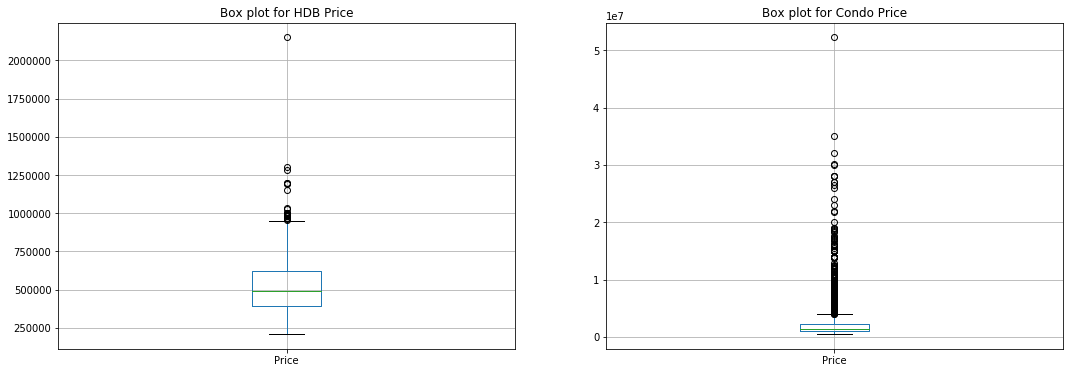

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,6))
HDB.boxplot(column='Price', ax=ax1)
ax1.set_title("Box plot for HDB Price")

Condo.boxplot(column='Price', ax=ax2)
ax2.set_title("Box plot for Condo Price")

In [63]:
#create a function to remove the outlieres
def outliers(str, HDB):
    HDB.reset_index(inplace=True,drop=True)
    iqr = HDB[str].quantile(0.75)-HDB[str].quantile(0.25) #find the iqr
    Upperb = HDB[str].quantile(0.75) + 1.5*iqr #find the upper and lower bound
    Lowerb = HDB[str].quantile(0.25) - 1.5*iqr 
    upper_outliers = (HDB[str] < Upperb) #true if the value lies within the boundary 
    HDB = HDB.drop(HDB.index[upper_outliers==False]) #remove if the value is false
    if sum(HDB[str] < Lowerb) == 0: #check if there is any outliers falling below the lower boundary, if 0, we have removed all the outliers 
        return HDB
    else:
        HDB.reset_index(inplace=True,drop=True) 
        Lower_outliers = (HDB[str] > Lowerb)
        HDB = HDB.drop(HDB.index[Lower_outliers==False])
        return HDB 

In [64]:
#removed outliers for the variable Price
HDB = outliers("Price", HDB)
Condo = outliers("Price", Condo)

print("The summary statistics for HDB: ")
print(Condo['Price'].describe()) 

print("\nThe summary statistics for Condo: ")
print(HDB['Price'].describe())

The summary statistics for HDB: 
count    3.769000e+03
mean     1.545158e+06
std      7.602493e+05
min      4.999000e+05
25%      9.700000e+05
50%      1.350000e+06
75%      1.850000e+06
max      4.000000e+06
Name: Price, dtype: float64

The summary statistics for Condo: 
count      2606.000000
mean     510429.222180
std      161153.448367
min      210000.000000
25%      395000.000000
50%      488000.000000
75%      611500.000000
max      950000.000000
Name: Price, dtype: float64


### 3.2.2 "Price_per_sqft" and "Land_Area" variables analysis by Type of property 

Text(0.5, 1.0, 'Box plot for Condo Land_Area')

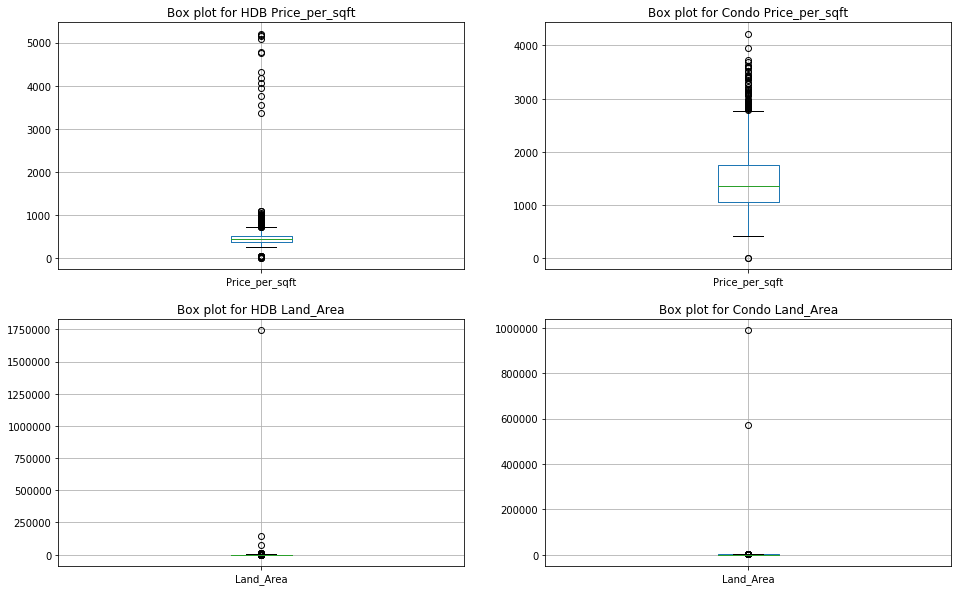

In [65]:
#box plot for significant variables "Price_per_sqft" and "Land Area"
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(16,10))

HDB.boxplot(column='Price_per_sqft', ax=ax1)
ax1.set_title("Box plot for HDB Price_per_sqft")
Condo.boxplot(column='Price_per_sqft', ax=ax2)
ax2.set_title("Box plot for Condo Price_per_sqft")

HDB.boxplot(column='Land_Area', ax=ax3)
ax3.set_title("Box plot for HDB Land_Area")
Condo.boxplot(column='Land_Area', ax=ax4)
ax4.set_title("Box plot for Condo Land_Area")


We removed outliers for variables like "Land_Area" and "Price_per_sqft" as those values have great differences in the summary statistics.

In [66]:
HDB = outliers("Land_Area", HDB)
HDB = outliers("Price_per_sqft", HDB)

Condo = outliers("Land_Area", Condo)
Condo = outliers("Price_per_sqft", Condo)

print("The dimension of the HDB data is: ", HDB.shape)
print("The dimension of the Condo data is: ", Condo.shape)

The dimension of the HDB data is:  (2408, 13)
The dimension of the Condo data is:  (3538, 13)


### 3.2.3 Analysis for other variables 

Text(0.5, 1.0, 'Box plot for Condo age_of_building')

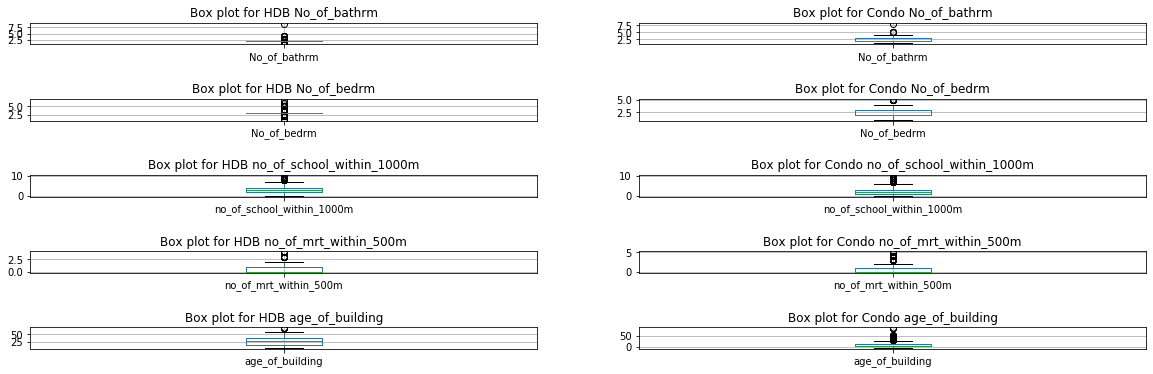

In [67]:
fig, ((ax5, ax6),(ax7, ax8),(ax9, ax10),(ax11, ax12),(ax13, ax14)) = plt.subplots(5, 2,figsize=(20,6))
plt.subplots_adjust( hspace=2.5)
HDB.boxplot(column='No_of_bathrm', ax=ax5)
ax5.set_title("Box plot for HDB No_of_bathrm")
Condo.boxplot(column='No_of_bathrm', ax=ax6)
ax6.set_title("Box plot for Condo No_of_bathrm")

HDB.boxplot(column='No_of_bedrm', ax=ax7)
ax7.set_title("Box plot for HDB No_of_bedrm")
Condo.boxplot(column='No_of_bedrm', ax=ax8)
ax8.set_title("Box plot for Condo No_of_bedrm")

HDB.boxplot(column='no_of_school_within_1000m', ax=ax9)
ax9.set_title("Box plot for HDB no_of_school_within_1000m")
Condo.boxplot(column='no_of_school_within_1000m', ax=ax10)
ax10.set_title("Box plot for Condo no_of_school_within_1000m")

HDB.boxplot(column='no_of_mrt_within_500m', ax=ax11)
ax11.set_title("Box plot for HDB no_of_mrt_within_500m")
Condo.boxplot(column='no_of_mrt_within_500m', ax=ax12)
ax12.set_title("Box plot for Condo no_of_mrt_within_500m")

HDB.boxplot(column='age_of_building', ax=ax13)
ax13.set_title("Box plot for HDB age_of_building")
Condo.boxplot(column='age_of_building', ax=ax14)
ax14.set_title("Box plot for Condo age_of_building")

In [68]:
frames = [HDB,Condo] 
removed_outliers = pd.concat(frames) #combine the two datasets together 
removed_outliers.head()

,Built,Land_Area,No_of_bathrm,No_of_bedrm,Price,Price_per_sqft,Tenure,Type,latitude,longitude,no_of_school_within_1000m,no_of_mrt_within_500m,age_of_building
0,1995,1270.0,2,3,546000.0,429.92,99-year Leasehold,HDB,1.345383,103.746046,3.0,0.0,25
1,1980,1270.0,2,3,678000.0,533.86,99-year Leasehold,HDB,1.373571,103.851554,2.0,1.0,40
2,1977,990.0,2,2,455000.0,459.60,99-year Leasehold,HDB,1.315350,103.770855,2.0,0.0,43
3,1999,1400.0,2,3,520000.0,371.43,99-year Leasehold,HDB,1.448271,103.813344,4.0,0.0,21
4,1985,905.0,2,3,350000.0,386.74,99-year Leasehold,HDB,1.372392,103.889038,6.0,1.0,35


##  4.1 Feature Selection
After data pre-processing and cleaning, the important features among the available set of features are selected as shown in the table below.

In [72]:
Data = shuffle(removed_outliers,random_state=30)
Data = Data.reset_index(drop=True)
Data['Built']=Data['Built'].astype(dtype=np.int32)
Data.dtypes

Built                          int32
Land_Area                    float64
No_of_bathrm                   int64
No_of_bedrm                    int64
Price                        float64
Price_per_sqft               float64
Tenure                        object
Type                          object
latitude                     float64
longitude                    float64
no_of_school_within_1000m    float64
no_of_mrt_within_500m        float64
age_of_building                int32
dtype: object

In [73]:
print('The table below shows some examples of the housing data :')
Data.head()

The table below shows some examples of the housing data :


,Built,Land_Area,No_of_bathrm,No_of_bedrm,Price,Price_per_sqft,Tenure,Type,latitude,longitude,no_of_school_within_1000m,no_of_mrt_within_500m,age_of_building
0,1974,699.0,2,2,385000.0,550.79,99-year Leasehold,HDB,1.304226,103.911165,3.0,0.0,46
1,2013,1270.0,3,3,2500000.0,1968.50,99-year Leasehold,Condo,1.268163,103.814379,0.0,0.0,7
2,2017,753.0,2,2,1090000.0,1447.54,99-year Leasehold,Condo,1.318212,103.761904,3.0,0.0,3
3,2019,495.0,1,1,800000.0,1616.16,99-year Leasehold,Condo,1.325030,103.890490,1.0,2.0,1
4,1997,1323.0,2,3,527000.0,398.34,99-year Leasehold,HDB,1.383111,103.766990,6.0,0.0,23


## 4.2 Summary Statistics

In [76]:
Data_d = Data.drop(['latitude','longitude'], axis=1) #drop the variables that are not significant to evaluate the statistics
Data_d.describe() #provide the descriptive statistics 

,Built,Land_Area,No_of_bathrm,No_of_bedrm,Price,Price_per_sqft,no_of_school_within_1000m,no_of_mrt_within_500m,age_of_building
count,5946.000000,5946.000000,5946.000000,5946.000000,5.946000e+03,5946.000000,5946.000000,5946.000000,5946.000000
mean,2003.340229,1066.692735,2.071813,2.604608,1.070747e+06,1040.387908,2.442146,0.530104,16.659771
std,13.981212,336.301483,0.682884,0.834237,7.155911e+05,611.858569,1.896063,0.876102,13.981212
min,1937.000000,344.000000,1.000000,1.000000,2.100000e+05,268.010000,0.000000,0.000000,-4.000000
25%,1995.000000,818.000000,2.000000,2.000000,5.230000e+05,459.662500,1.000000,0.000000,6.000000
50%,2009.000000,1044.000000,2.000000,3.000000,8.600000e+05,953.555000,2.000000,0.000000,11.000000
75%,2014.000000,1281.000000,2.000000,3.000000,1.420000e+06,1470.590000,3.000000,1.000000,25.000000
max,2024.000000,2121.000000,9.000000,7.000000,4.000000e+06,2808.610000,10.000000,5.000000,83.000000


Based on the above statistical analysis, the mean pricing for Singapore houses are around SGD <b>1,070,747</b> and the median pricing are around SGD <b>860,000</b>. The reasons for the difference, might be attributed to higher Condo listings percentage compared to the HDB listings, hence the mean would be higher as Condo listings are generally more expensive than HDB.

Comparing the the number of school and mrt near each listing, there are average of 2 schools and 1 mrt station near each listings. 

To understand the statistical analysis for the different types of housings, we further analyse the different properties. 

### 4.3 Price analysis based on the Type of housing 

In [77]:
# Price analysis by house type 
Data_d[Data_d["Type"]=="HDB"].describe()

,Built,Land_Area,No_of_bathrm,No_of_bedrm,Price,Price_per_sqft,no_of_school_within_1000m,no_of_mrt_within_500m,age_of_building
count,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000,2408.000000
mean,1993.186462,1099.161545,1.981312,2.941860,492708.087625,450.442355,3.291113,0.337625,26.813538
std,14.188114,266.532918,0.380321,0.613469,147807.247152,91.009140,1.906947,0.606882,14.188114
min,1949.000000,430.000000,1.000000,1.000000,210000.000000,268.010000,0.000000,0.000000,4.000000
25%,1983.000000,958.000000,2.000000,3.000000,388000.000000,383.252500,2.000000,0.000000,15.000000
50%,1991.500000,1108.000000,2.000000,3.000000,475000.000000,435.110000,3.000000,0.000000,28.500000
75%,2005.000000,1291.000000,2.000000,3.000000,582750.000000,500.712500,4.000000,1.000000,37.000000
max,2016.000000,1841.000000,9.000000,7.000000,948888.000000,723.140000,10.000000,4.000000,71.000000


Based on the above statistical analysis, we evaluated that the mean pricing for HDB houses is SGD 492,708 and the median is SGD 475,000. 

In [78]:
Data_d[Data_d["Type"]=="Condo"].describe()

,Built,Land_Area,No_of_bathrm,No_of_bedrm,Price,Price_per_sqft,no_of_school_within_1000m,no_of_mrt_within_500m,age_of_building
count,3538.000000,3538.000000,3538.000000,3538.000000,3.538000e+03,3538.000000,3538.000000,3538.000000,3538.000000
mean,2010.250989,1044.594121,2.133409,2.375071,1.464166e+06,1441.911054,1.864330,0.661108,9.749011
std,8.579109,374.895164,0.822195,0.885162,6.808263e+05,474.759959,1.656276,0.998538,8.579109
min,1937.000000,344.000000,1.000000,1.000000,4.999000e+05,411.440000,0.000000,0.000000,-4.000000
25%,2006.000000,754.000000,2.000000,2.000000,9.500000e+05,1074.407500,1.000000,0.000000,4.000000
50%,2014.000000,1012.000000,2.000000,2.000000,1.288000e+06,1370.550000,2.000000,0.000000,6.000000
75%,2016.000000,1280.000000,3.000000,3.000000,1.720000e+06,1745.232500,3.000000,1.000000,14.000000
max,2024.000000,2121.000000,8.000000,5.000000,4.000000e+06,2808.610000,10.000000,5.000000,83.000000


Based on the above statistical analysis, we evaluated that the mean pricing for condo houses is SGD 1,464,166 and the median is SGD 1,288,000. Based on the results, we conclude that both HDB and Condo has a great difference in pricing. 

Generally, we observed that the number of mrt near condo listings has a mean of 1 while, HDB has mean of 0. This suggests that Condo are generally nearer to MRT stations compared to HDB. However, HDB has a higher number of schools nearby compared to Condo. 

In [79]:
No_of_housing = Data.shape[0]
No_of_HDB_housing = np.sum(Data["Type"]=="HDB")
No_of_Condo_housing = np.sum(Data["Type"]=="Condo")
p_HDB = (No_of_HDB_housing/No_of_housing)*100
p_condo = (No_of_Condo_housing/No_of_housing)*100 
print("The percentage of HDB housing is", round(p_HDB,2), '%')
print("The percentage of Condo housing is",round(p_condo,2) , '%')

The percentage of HDB housing is 40.5 %
The percentage of Condo housing is 59.5 %


## 4.4 Listing Distribution in Singapore 
The geographic distribution of the house listings is shown below: 

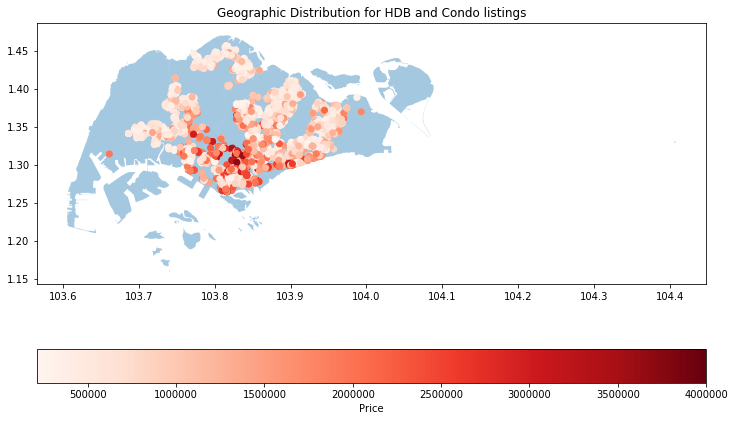

In [38]:
#Extract the coordinates for each listing 
house_geo = Data.drop(['Built','Land_Area','No_of_bathrm','No_of_bathrm','No_of_bedrm','Price_per_sqft','no_of_school_within_1000m','no_of_mrt_within_500m',
                      'age_of_building','Tenure'], axis=1)
#Form new dataframe for geo_coordinates 
gdf = geopandas.GeoDataFrame(
    house_geo, geometry=geopandas.points_from_xy(house_geo.longitude, house_geo.latitude))
#Input the base map for Singapore
street_map = geopandas.read_file('igismap/poly.shp')

#plot the geographical distribution map 
fig,ax = plt.subplots(figsize=(12,8))
street_map.plot(ax=ax, alpha = 0.4) #plot the base map 
ax.set_title('Geographic Distribution for HDB and Condo listings')
gdf.plot(column='Price', ax=ax,legend=True,legend_kwds={'label': "Price",'orientation': "horizontal"},cmap='Reds') #plot the listing coordinates to the Singapore map

From the graph above, we observed that the housing price tend to increase when houses are located nearer to central/downtown region. The housing price tends to be on the lower end when it is located around non-central region. 

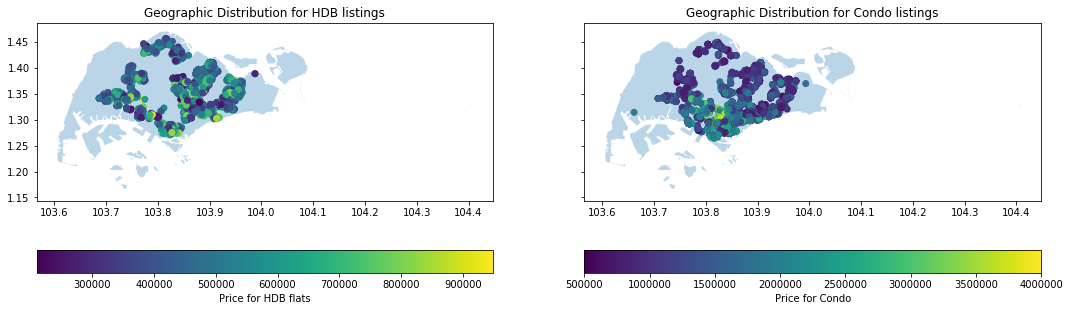

In [39]:
#plot the geographical map respective to their property 
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,6), sharey=True)
#plot HDB location 
street_map.plot(ax=ax1, alpha = 0.3)
ax1.set_title('Geographic Distribution for HDB listings')
gdf[gdf["Type"]=="HDB"].plot(column='Price', ax=ax1, legend=True,legend_kwds={'label': "Price for HDB flats",'orientation': "horizontal"})

#plot Condo location 
street_map.plot(ax=ax2, alpha = 0.3)
ax2.set_title('Geographic Distribution for Condo listings')
gdf[gdf["Type"]=="Condo"].plot(column='Price', ax=ax2, legend=True,legend_kwds={'label': "Price for Condo",'orientation': "horizontal"})


From the HDB geographic distribution, we observed that majority of the listings are outside of the central areas. For regions that are near central, the housing price tends to be at the upper-end of the scale.

To some extent, some condo listings are in central area and housing price are tend to be more expensive compared to other regions. 

## 4.5 Univariate Analysis 

### 4.5.1 Price analysis by Tenure 

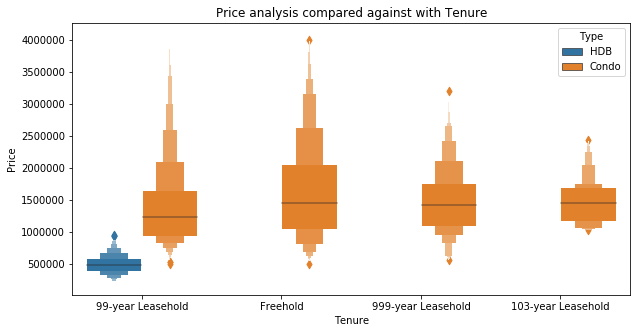

In [80]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Price analysis compared against with Tenure')
sns.boxenplot(x="Tenure", y="Price", data=Data, hue = 'Type', ax=ax)

From the graph above, we can conclude that the mean price for condo for 99 year leasehold is slightly lower than the other types of leasehold.

In [117]:
mask_hdb = Data['Type'] == 'HDB'
mask_condo = Data['Type'] == 'Condo'

### 4.5.2 Price analysis on built variable 

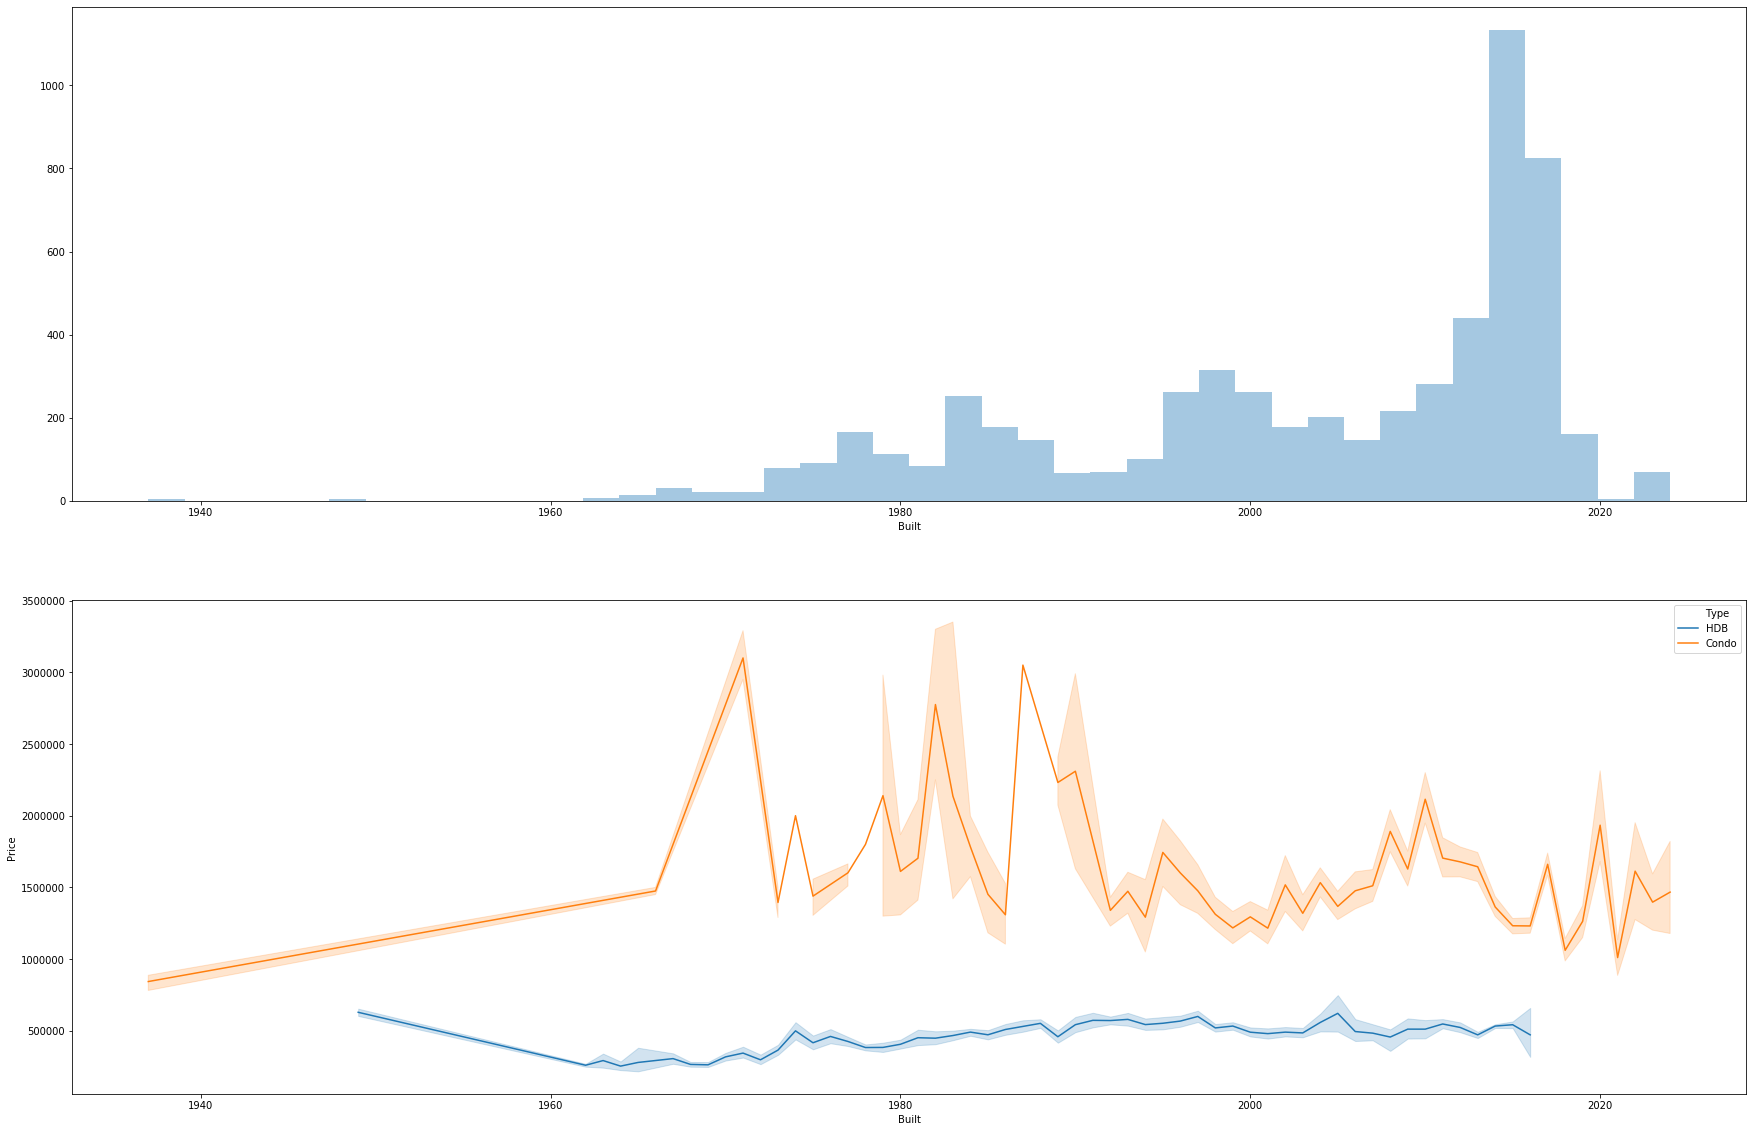

In [123]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(30,20))
sns.distplot(Data['Built'], kde=False , ax=ax1)
sns.lineplot(x='Built', y='Price', data=Data,hue = 'Type', ax=ax2)

<p>The year of construction is important for HDB, as it generally increases the later the years. For Condo, the year built seems to be noisy.</p>

### 4.5.3 Boxplot analysis for Price, Price_per_sqft and Land_Area 

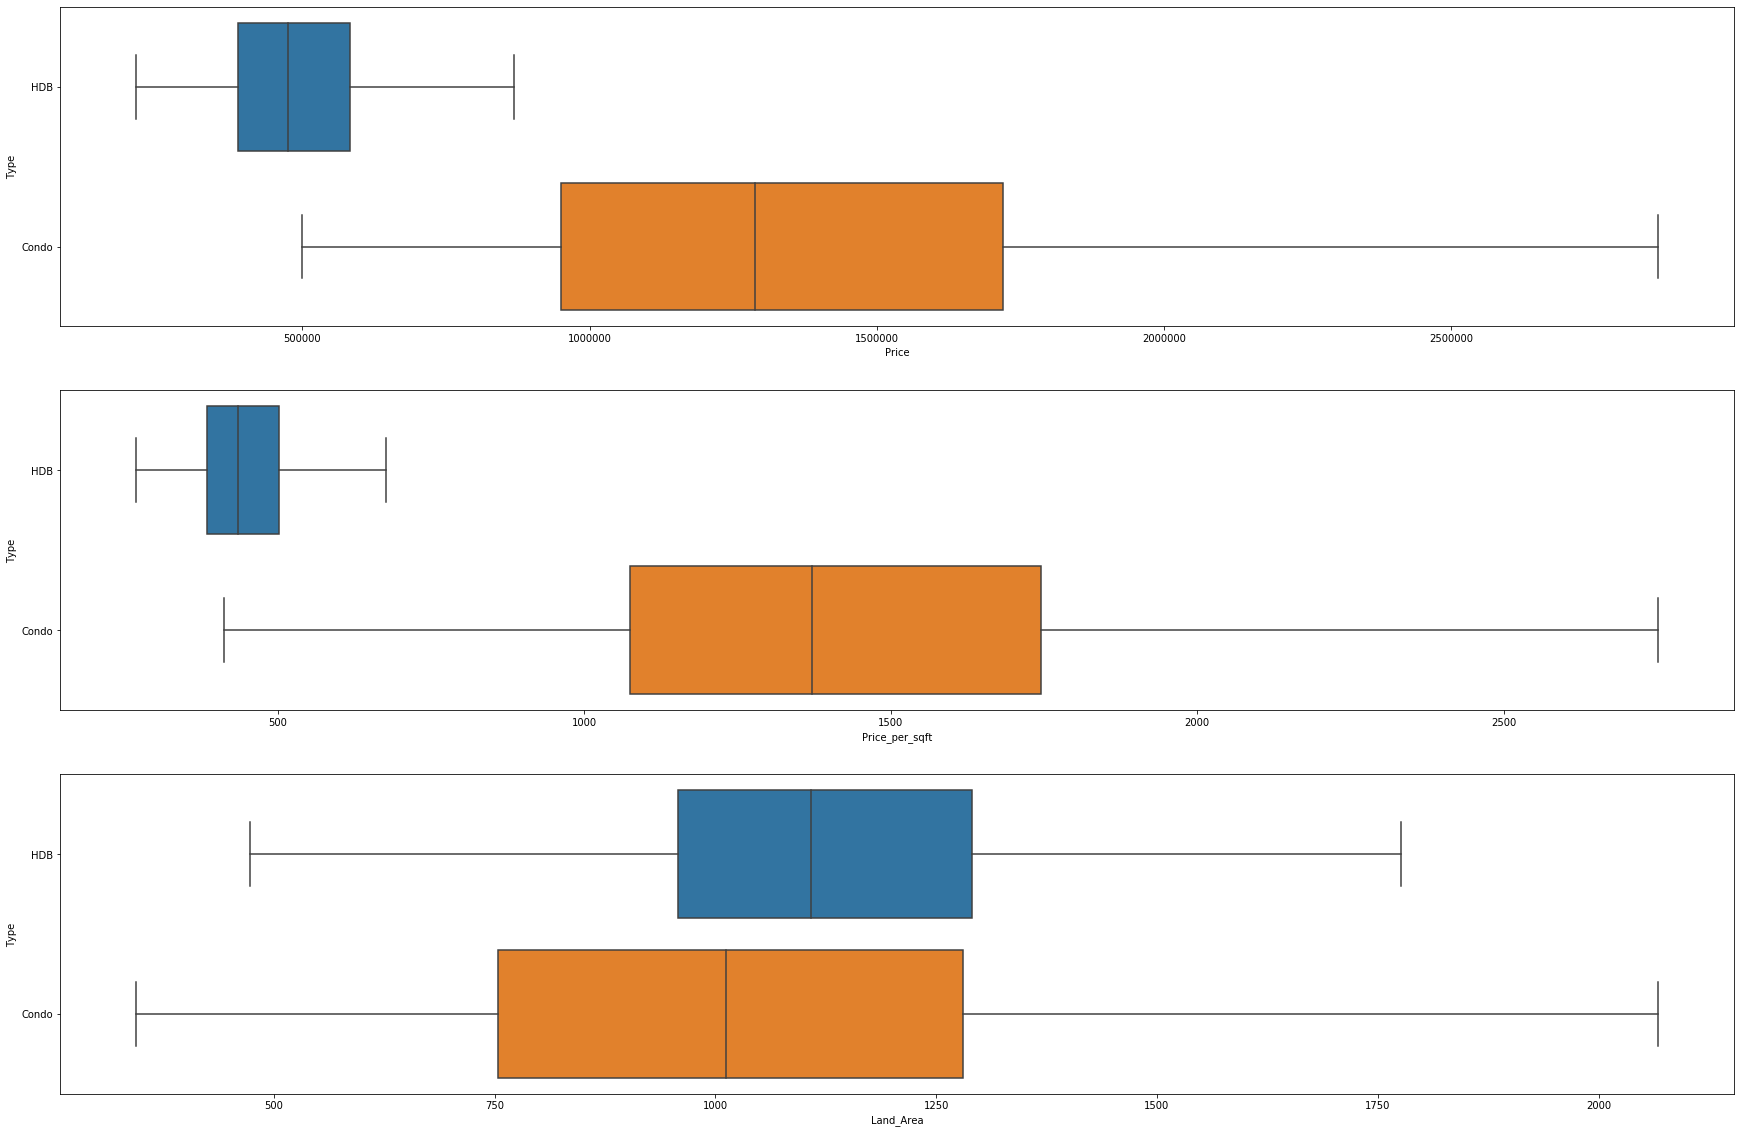

In [116]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(30,20))
sns.boxplot(y='Type', x='Price', data= Data, showfliers = False, ax=ax1)
sns.boxplot(y='Type', x='Price_per_sqft', data= Data, showfliers = False, ax=ax2)
sns.boxplot(y='Type', x='Land_Area', data=Data, showfliers = False,ax=ax3)

### 4.5.4 Price analysis on no of bedrooms, bathrooms, school and mrt station variables 

Text(0.5, 1.0, 'Price analysis by no of bedrooms')

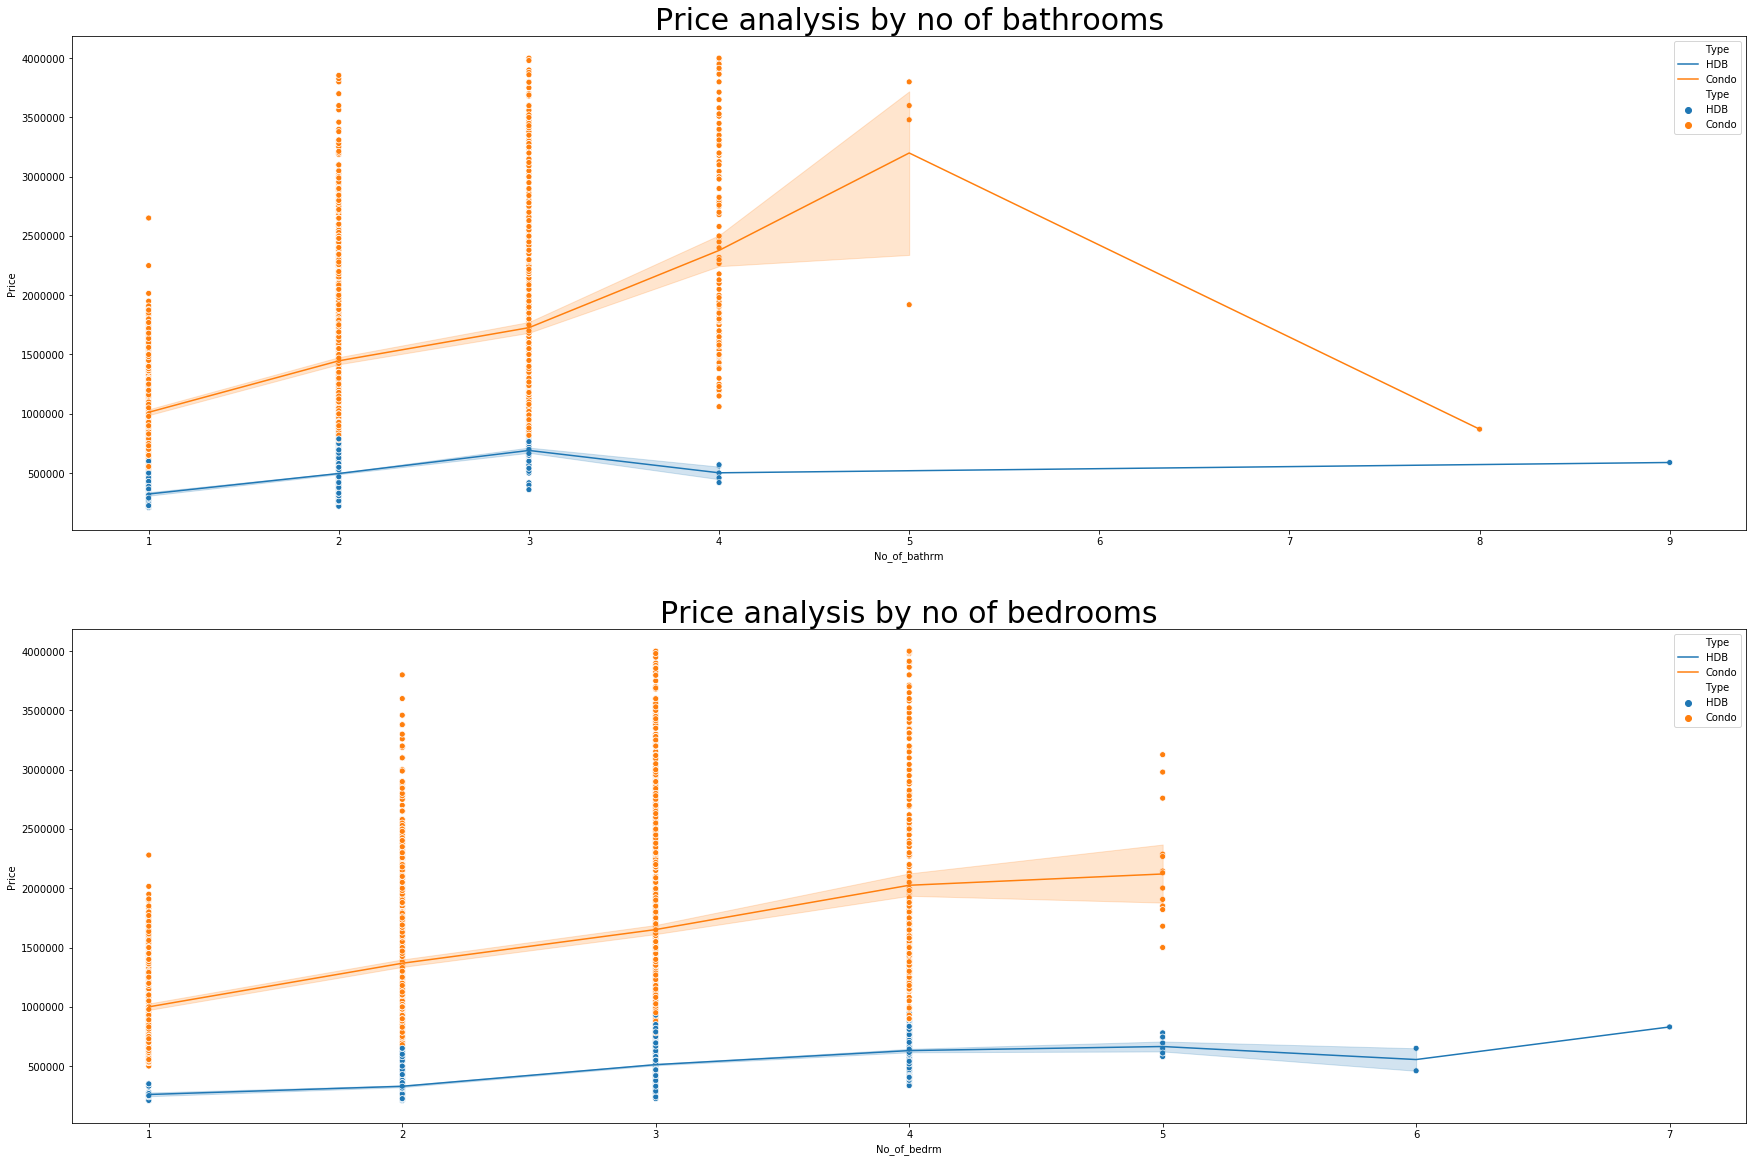

In [129]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(30,20))
sns.scatterplot(x='No_of_bathrm', y='Price', data=Data,hue = 'Type',ax=ax1)
sns.lineplot(x='No_of_bathrm', y='Price', data=Data,hue = 'Type',ax=ax1)
ax1.set_title('Price analysis by no of bathrooms',size=30)
sns.scatterplot(x='No_of_bedrm', y='Price', data=Data, hue = 'Type',ax=ax2)
sns.lineplot(x='No_of_bedrm', y='Price', data=Data,hue = 'Type',ax=ax2)
ax2.set_title('Price analysis by no of bedrooms', size=30)

<p>The number of bathrooms and bedrooms are more important to a HDB apartment. For condominiums, there is a sharp increase in price when the number of bath/bedrooms increases from 3. </p>

Text(0.5, 1.0, 'Price analysis by no of bedrooms')

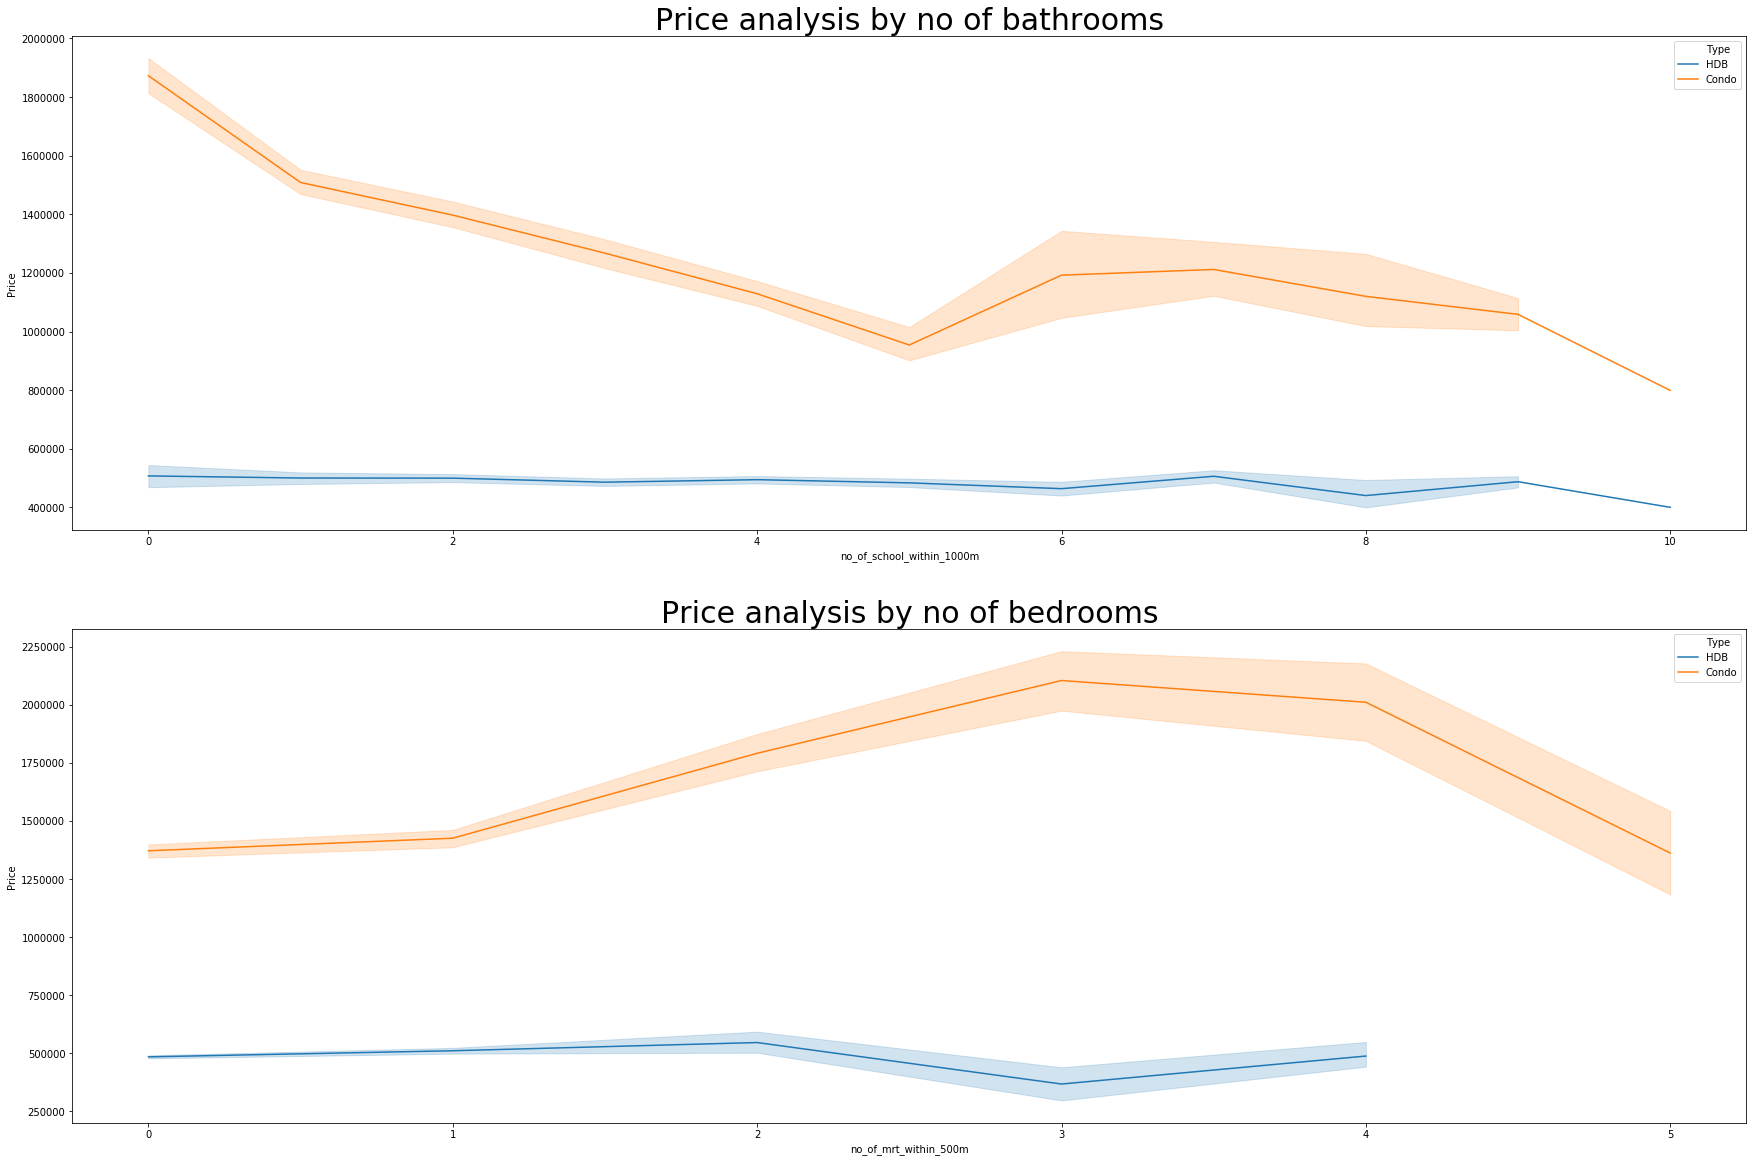

In [130]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(30,20))
sns.lineplot(x='no_of_school_within_1000m', y='Price',hue= 'Type', data=Data, ax=ax1)
ax1.set_title('Price analysis by no of bathrooms',size=30)
sns.lineplot(x='no_of_mrt_within_500m', y='Price', hue= 'Type', data=Data, ax=ax2)
ax2.set_title('Price analysis by no of bedrooms', size=30)

<p>Fo number of schools, 1 school is preferred for HDB. Otherwise, the price drops quickly as the number of schools increases.</p>

<p>Generally, MRT stations are highly sought after in condo and HDBs. The sharp increase in landed price for 2 MRT stations might be a statistical artifact.</p>

## 4.6 Scatterplot Matrix and Correlation heatplot 

The scatterplot matrix provides a overview on the relationship between each variables. By examing the scatterplot matrix, we can derive if there is any correlation between each predictor variables and response variable to understand the significant of each variable in the pricing model. 

In addition, we would be able to examine the correlation between each variables to understand if all predictor variables are independent from each other. 

In [81]:
Data1 = Data.drop(['latitude','longitude'], axis=1) #remove the coordinates from the data

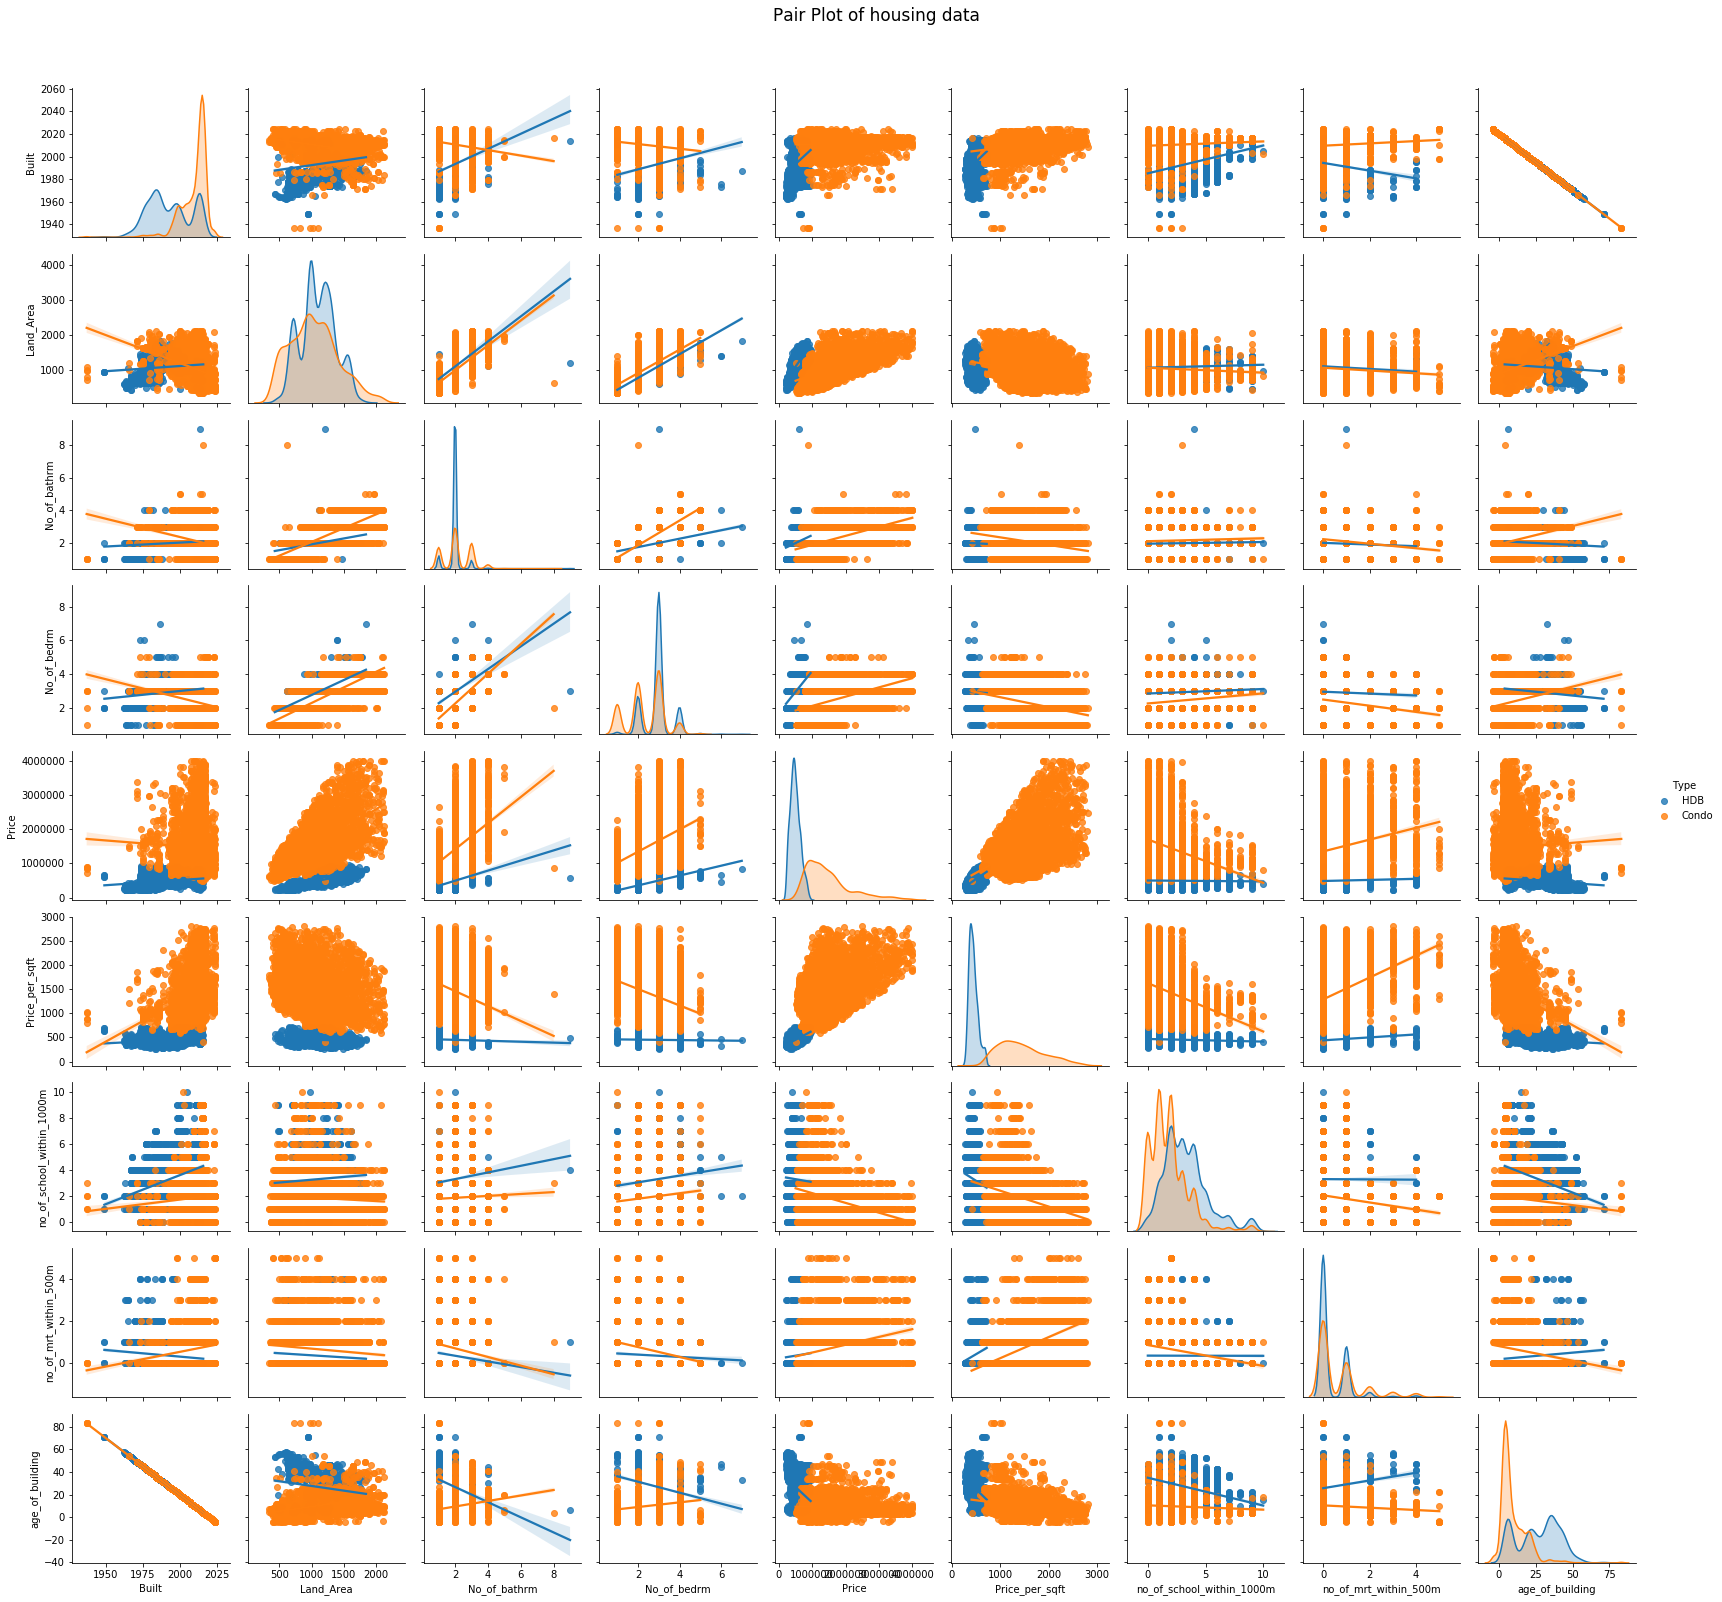

In [99]:
sns.pairplot(Data1, hue= 'Type',kind="reg") #create the scatterplot matrix and seperate by the type of housing 
plt.subplots_adjust(top=0.93)
plt.suptitle('Pair Plot of housing data', size = 17);

Based on the scatterplot matrix, there does not seems to have a strong linear relationship between the predictor variables and the price variable. However, there seems to have some positive correlation between price and predictor variables like "Land_area", "no of bedrm", "no of bathrm", "Price_per_sqft", and "no of mrt". On the other hand, there seems to have some negative correlation between price and predictor variables like "age_of_building" and "no of school". 

In general, there seems to have some correlation between the predictor variables which might suggest multicollinearity in the data. 

Lastly, based on the histogram plot, most of the variables seems to be normally distributed but some has skewed distribution, like number of mrt station and number of bathrm. 

(9.0, 0.0)

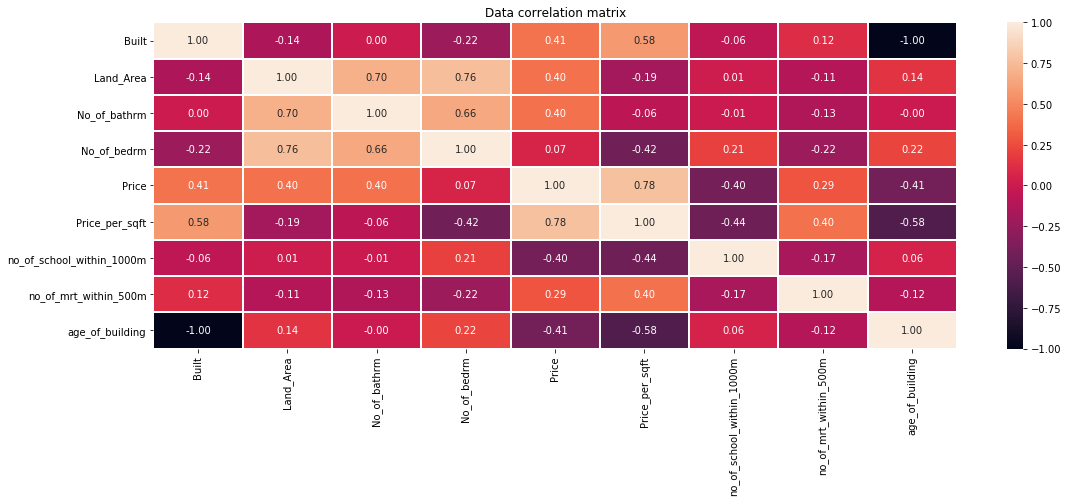

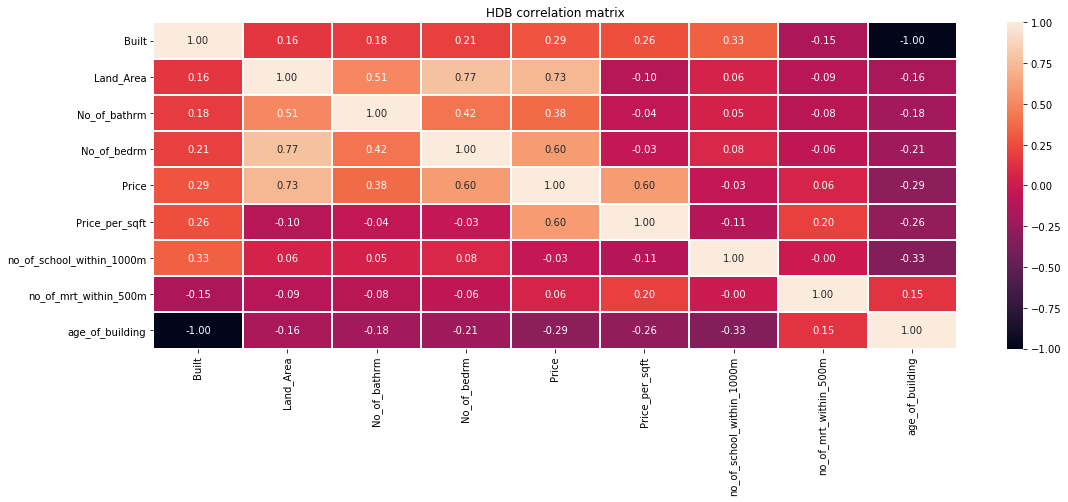

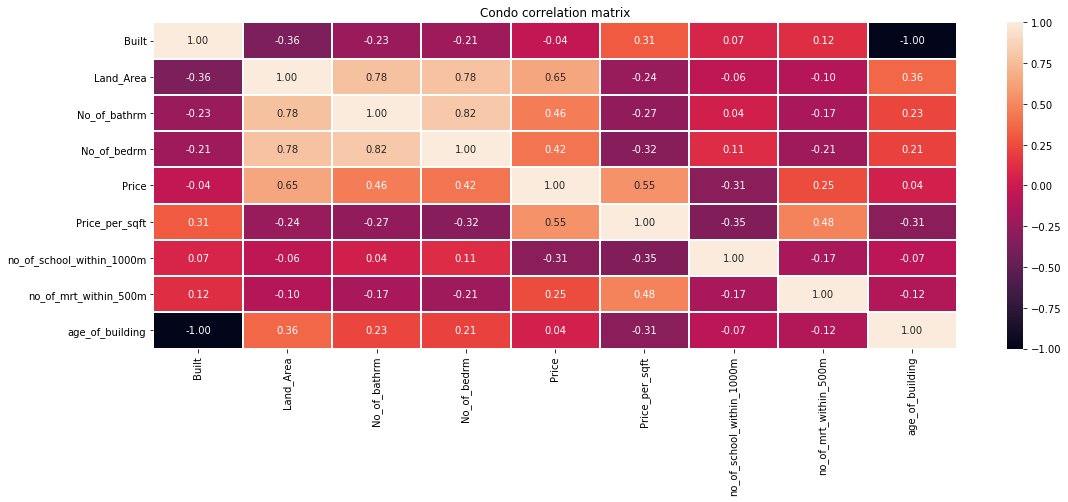

In [94]:
fig,ax1= plt.subplots(figsize=(18,6))

#plot the correlation matrix as heatplot regardless of the type of housing 
corr = Data1.corr(method="pearson")
sns.heatmap(corr,annot=True,linecolor='white', linewidth=1, fmt='.2f',ax=ax1)
ax1.set_title('Data correlation matrix')
bottom, top = ax1.get_ylim() #to obtain the y values for the top and bottom
ax1.set_ylim(bottom + 0.5, top - 0.5) #adjust the position, such that it will not be cut off, as the original plot cuts off the top and bottom part of the heatplot 

fig,ax2= plt.subplots(figsize=(18,6))
corr1 = Data1[Data1["Type"]=="HDB"].corr(method="pearson")
sns.heatmap(corr1,annot=True, linecolor='white', linewidth=1, fmt='.2f',ax=ax2)
ax2.set_title('HDB correlation matrix')
bottom, top = ax2.get_ylim()
ax2.set_ylim(bottom + 0.5, top - 0.5)


fig,ax3= plt.subplots(figsize=(18,6))
corr2 = Data1[Data1["Type"]=="Condo"].corr(method="pearson")
sns.heatmap(corr2,annot=True, linecolor='white', linewidth=1, fmt='.2f',ax=ax3)
ax3.set_title('Condo correlation matrix')
bottom, top = ax3.get_ylim()
ax3.set_ylim(bottom + 0.5, top - 0.5)


**Analysis**

Based on the data correlation matrix, "Price_per_sqft", "Land_Area", "Built" and "No_of_bathrm" seems to have positively medium to high correlation, while "number of school" and "age of building" seems to have negatively correlation to the "Price" variable. In general, there are some strong correlation among Land area, no of bathroom and bedroom. This could pose a problem in linear regression model as the correlation between predictor variables leads to multicollinearity.

Based on the HDB correlation matrix, "Price_per_sqft", "Land_Area" and "No_of_bedrm" seems to have positively high correlation, compared to the "Price" variable. There is some strong correlation among Land area and no of bedroom. Variables like "no of school", "no of mrt" and "age of building" seems to have a low correlation to other predictor variables, this might suggest that these variables might be independent variable. 

Based on the Condo correlation matrix, "Price_per_sqft", "Land_Area", "Built", "No of bedrm" and "No_of_bathrm" seems to have positively medium to high correlation to the "Price" variable. There is some strong correlation among Land area, no of bathrm and no of bedroom. This aligns with our conclusion in data correlation matrix.  

In [ ]:
## 4.7 Univariate Analysis 